In [73]:
import pandas as pd
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as ntx
import re
import altair as alt

# ref doc https://github.com/eliorc/node2ve and https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
from node2vec import Node2Vec 
from sklearn.model_selection import train_test_split
from music_utils import *
from tqdm.auto import tqdm  # import tqdm for progress bar
tqdm.pandas()

from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx, from_networkx
import torch
from torch import nn
from torch_geometric.nn import GCNConv
import torch_geometric.nn as graphnn
import torch.nn.functional as F
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
import networkx as nx

import shap
shap.initjs()

In [74]:
local = True
if local:
    DATA_PATH = '../Music_project/data/'
else:
    DATA_PATH = './data/'

In [75]:
def graph_largest_cc(nodes_df, plot_graph=False, write_graphml=None):   
    edge_list = [tuple(l[:2]) for l in nodes_df.values.tolist()]
    G = ntx.from_edgelist(edge_list)
    largest_cc = G.subgraph(max(ntx.connected_components(G), key=len))
    print(f'The largest connected component has {len(largest_cc.nodes)} nodes.')
    print(f'The largest connected component has {len(largest_cc.edges)} edges.')

    if plot_graph:
        fig, ax = plt.subplots(figsize=(15, 15))
        ntx.draw_networkx(largest_cc, with_labels=False, node_size = 20, ax = ax)
        plt.show()
    
    if write_graphml != None:
        ntx.write_graphml_lxml(G, write_graphml+'.graphml')
    return G, largest_cc

# Spotify 600k songs

In [76]:
spotify_600, artists_600 = read_spotify_600(DATA_PATH=DATA_PATH, read=True)

In order to keep only music, we will filter the songs based on the speechiness. Indeed, if a song is from an audio-book or so, it will have a high speechiness score. Hence, we will filter out songs that have a speechiness score that is higher than 0.7.

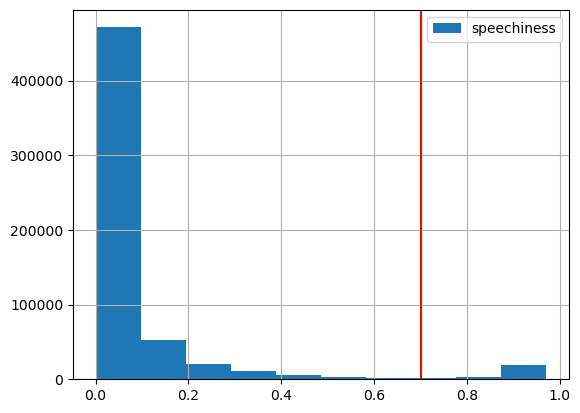

In [77]:
spotify_600["speechiness"].hist(legend = "Speechiness").axvline(x = 0.7, color = "red")

In [78]:
# Filter out non-music
n_non_music = sum(spotify_600["speechiness"] > 0.7)
print(f"We are deleting {n_non_music} songs from the dataframe")
spotify_600 = spotify_600[spotify_600["speechiness"] < 0.7]

#Nodes creation
feat_track_600 = spotify_600[(spotify_600.num_artists > 1)&(spotify_600.release_date.dt.year > 1999)].copy()
nodes_600 = nodes_featuring(feat_track_600, DATA_PATH=DATA_PATH, read=True, path='edge_list_600k_over1999.pkl')

#artists feature creation
artists_600_features = artists_features_creation(artists_600, spotify_600, DATA_PATH, read=True)

#Genres
genres = pd.DataFrame(artists_600_features.genres.explode().value_counts().reset_index()).dropna().rename(
    columns={'index':'genre','genres':'number_of_artists'}
)

We are deleting 22100 songs from the dataframe


In [79]:
edge_list = [tuple(l[:2]) for l in nodes_600.values.tolist()]
G = ntx.from_edgelist(edge_list)
largest_cc = G.subgraph(max(ntx.connected_components(G), key=len))
print(f'The largest connected component has {len(largest_cc.nodes)} nodes.')
print(f'The largest connected component has {len(largest_cc.edges)} edges.')

The largest connected component has 20500 nodes.
The largest connected component has 62429 edges.


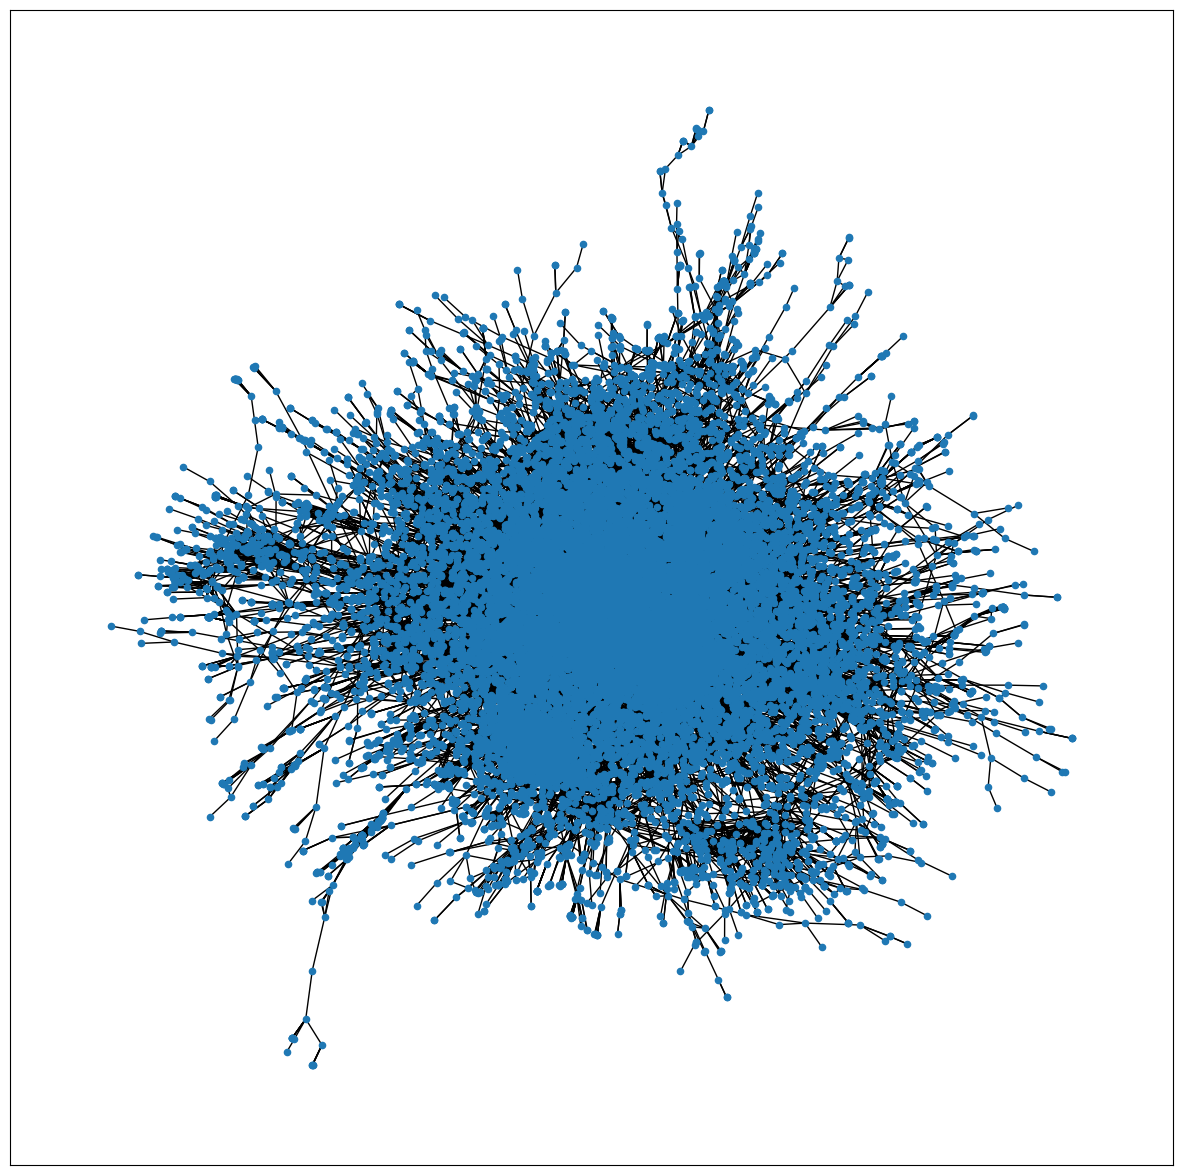

In [80]:
# didn't work on my local computer, but did work on colab, some issue with the installed networkx version
fig, ax = plt.subplots(figsize=(15, 15))
ntx.draw_networkx(largest_cc, with_labels=False, node_size = 20, ax = ax)

# Node regression

In [12]:

class NodeRegression:
    def __init__(self) -> None:
        self.cols_for_reg = [
            "followers","num_genres", 'avg_duration_ms', 'avg_explicit', 'avg_danceability', 'avg_energy', 'avg_key',
            'avg_loudness', 'avg_mode', 'avg_speechiness', 'avg_acousticness', 'avg_instrumentalness',
            'avg_liveness', 'avg_valence', 'avg_tempo', 'avg_time_signature', "artist_popularity"
        ]
        self.cols_to_drop = [
            "avg_track_popularity", "name", "genres"
        ]

    def create_data(self, artists_600_features, nodes_600):
        """Function to create graph and dataframe with features. We only keep artists in the graph if they have features associated to him or her.
        We also remove artists with null values."""
        # Subset graph based on feature availability
        artists_features_set = set(artists_600_features.index)
        edge_list_features = [tuple(l[:2]) for l in nodes_600.values.tolist() if (l[0] in artists_features_set and l[1] in artists_features_set)]
        G = ntx.from_edgelist(edge_list_features)
        g = G.subgraph(max(ntx.connected_components(G), key=len))
        df = artists_600_features.loc[list(g.nodes)]
        # Remove artists with NAs
        g = nx.Graph(g)
        artists_with_na = df[df.isnull().sum(axis=1) > 0].index
        g.remove_nodes_from(artists_with_na)
        df = df.dropna()
        if not nx.is_connected(g):
            print("Warning: Graph is not connected")
        # Add node attributes to graph
        g = self.add_node_attr(g, df)
        return g, df
    
    def get_df_reg(self, df):
        return df[self.cols_for_reg]
    

    def add_node_attr(self, graph, df):
        """Adds node attributes to networkx graph"""
        dict = df.to_dict(orient="index")
        nx.set_node_attributes(graph, dict)
        return graph
    

    def fit_DW(self, graph, dims = 5, walk_length = 20, num_walks = 5, window = 2):
        """Compute DeepWalk embeddings"""
        deepwalk = DeepWalk(graph, dims=dims, walk_length = walk_length, num_walks=num_walks, window = window)
        walks = deepwalk.generate_walks()
        embeddings = deepwalk.skipgram()
        return embeddings
    
    def append_DW_embeddings(self,graph, df, dims = 5, walk_length = 20, num_walks = 5, window = 2):
        """Add DeepWalk embeddings to dataframe df"""
        id_to_number = dict(zip(graph.nodes, list(range(len(graph.nodes)))))
        number_to_id = dict(zip(list(range(len(graph.nodes))), graph.nodes))
        embeddings = self.fit_DW(graph, dims=dims, walk_length = walk_length,  num_walks=num_walks, window = window)
        embeddings_df = pd.DataFrame([embeddings[id_to_number[node]] for node in graph.nodes()], columns = [f"DW_{i}" for i in range(1, dims+1)])
        embeddings_df['idx'] = [number_to_id[node] for node in embeddings_df.index]
        embeddings_df = embeddings_df.set_index('idx')
        df = df.merge(embeddings_df, how = 'left',left_index = True, right_index = True)
        return df
    
    

    def append_graph_criteria(self, graph, df):
        """Add Graph criteria to the feature dataframe of a graph"""
        print("Computing degree")
        degrees = pd.Series(ntx.degree_centrality(graph))
        print("Computing closeness")
        closeness = pd.Series(ntx.closeness_centrality(graph))
        print("Computing load_centrality")
        load = pd.Series(ntx.load_centrality(graph))
        centralities = pd.concat([degrees,closeness,load], axis = 1)
        centralities.columns = ['Degree', 'Closeness', 'Load']
        df = df.merge(centralities, how = 'left',left_index = True, right_index = True)  
        return df


    def prepare_data_reg(self, df, test_size = 0.2, normalize = True):
        """Prepare data for OLS"""
        df = df.dropna()
        y = df["artist_popularity"]
        print("Dropped", self.cols_to_drop)
        X = df.drop(self.cols_to_drop + ["artist_popularity"], axis= 1)
        if normalize:
            X = (X-X.mean())/X.std()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        return X, y, X_train, X_test, y_train, y_test
    

    def get_graph_df_graph(self, artists_600_features, nodes_600, include_DW = True, include_graph_criteria = True):
        """Wrapper which creates a graph and a feature dataframe"""
        graph, df_graph = self.create_data(artists_600_features, nodes_600)
        if include_DW:
            df_graph = self.append_DW_embeddings(graph, df_graph)
        if include_graph_criteria:
            df_graph = self.append_graph_criteria(graph, df_graph)
        return graph, df_graph

    def fit_evaluate_ols(self, X_train, X_test, y_train, y_test):
        """Fit on train and evaluate OLS on test set"""
        ols = LinearRegression()
        ols.fit(X_train, y_train)
        r2 = ols.score(X_test, y_test)
        print("R2 score:", round(r2, 4))
        return ols

    

In [44]:
node_reg = NodeRegression()
graph, df_graph = node_reg.get_graph_df_graph(artists_600_features, nodes_600, include_graph_criteria=True, include_DW=True)
features = df_graph.drop(node_reg.cols_to_drop +["artist_popularity"] , axis= 1).columns
print(f'The largest connected component has {len(graph.nodes)} nodes.')
print(f'The largest connected component has {len(graph.edges)} edges.')

Computing degree
Computing closeness
Computing load_centrality
The largest connected component has 16908 nodes.
The largest connected component has 52233 edges.


In [45]:
X, y, X_train, X_test, y_train, y_test = node_reg.prepare_data_reg(df_graph, normalize = True)

Dropped ['avg_track_popularity', 'name', 'genres']


### OLS

In [46]:
node_reg.fit_evaluate_ols(X_train, X_test, y_train, y_test)

R2 score: 0.4966


LinearRegression()

### XGBoost

R2 score: 0.7563


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

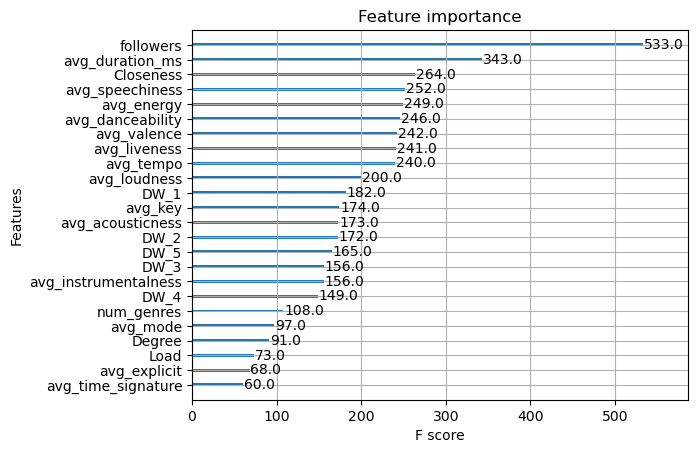

In [146]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb.get_booster().feature_names = list(features)
r2 = xgb.score(X_test, y_test)
print("R2 score:", round(r2, 4))
plot_importance(xgb.get_booster())

In [47]:
parameters = {'max_depth':[3, 5],"eta": [0.1, 0.3, 0.7], "gamma": [10, 20], 'reg_lambda': [1, 2, 5]}
xgb = XGBRegressor()
grid = GridSearchCV(xgb, parameters, verbose = 2)
grid.fit(X,y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .......eta=0.1, gamma=10, max_depth=3, reg_lambda=1; total time=   0.7s
[CV] END .......eta=0.1, gamma=10, max_depth=3, reg_lambda=1; total time=   0.7s
[CV] END .......eta=0.1, gamma=10, max_depth=3, reg_lambda=1; total time=   0.8s
[CV] END .......eta=0.1, gamma=10, max_depth=3, reg_lambda=1; total time=   0.7s
[CV] END .......eta=0.1, gamma=10, max_depth=3, reg_lambda=1; total time=   0.7s
[CV] END .......eta=0.1, gamma=10, max_depth=3, reg_lambda=2; total time=   0.7s
[CV] END .......eta=0.1, gamma=10, max_depth=3, reg_lambda=2; total time=   0.6s
[CV] END .......eta=0.1, gamma=10, max_depth=3, reg_lambda=2; total time=   0.7s
[CV] END .......eta=0.1, gamma=10, max_depth=3, reg_lambda=2; total time=   0.7s
[CV] END .......eta=0.1, gamma=10, max_depth=3, reg_lambda=2; total time=   0.7s
[CV] END .......eta=0.1, gamma=10, max_depth=3, reg_lambda=5; total time=   0.7s
[CV] END .......eta=0.1, gamma=10, max_depth=3,

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'eta': [0.1, 0.3, 0.7], 'gamma': [10, 20],
                         'max_depth': [3, 5], 'reg_lambda': [1, 2, 5]},
             verbose=2)

In [48]:
grid.best_score_

0.7408639054170696

In [49]:
grid.best_params_

{'eta': 0.1, 'gamma': 20, 'max_depth': 5, 'reg_lambda': 1}

R2 score: 0.7635


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

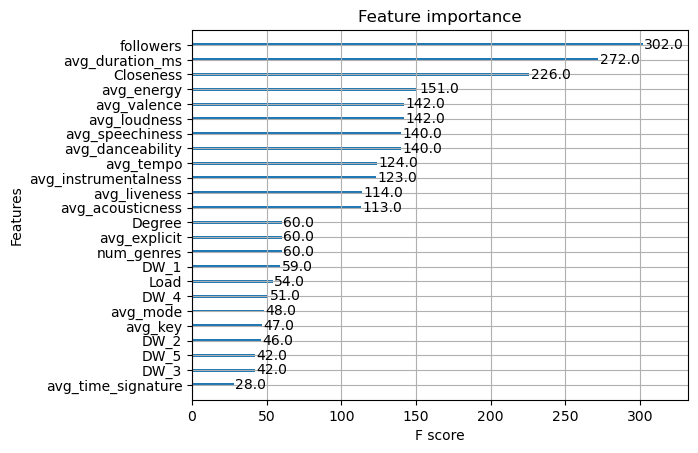

In [50]:
# Run best model on test set
xgb = XGBRegressor(**{'eta': 0.1, 'gamma': 20, 'max_depth': 5, 'reg_lambda': 1})
xgb.fit(X_train, y_train)
xgb.get_booster().feature_names = list(features)
r2 = xgb.score(X_test, y_test)
print("R2 score:", round(r2, 4))
plot_importance(xgb.get_booster())

In [51]:

# make sure the SHAP values add up to marginal predictions
pred = xgb.predict(X_train, output_margin=True)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


6.866455e-05

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


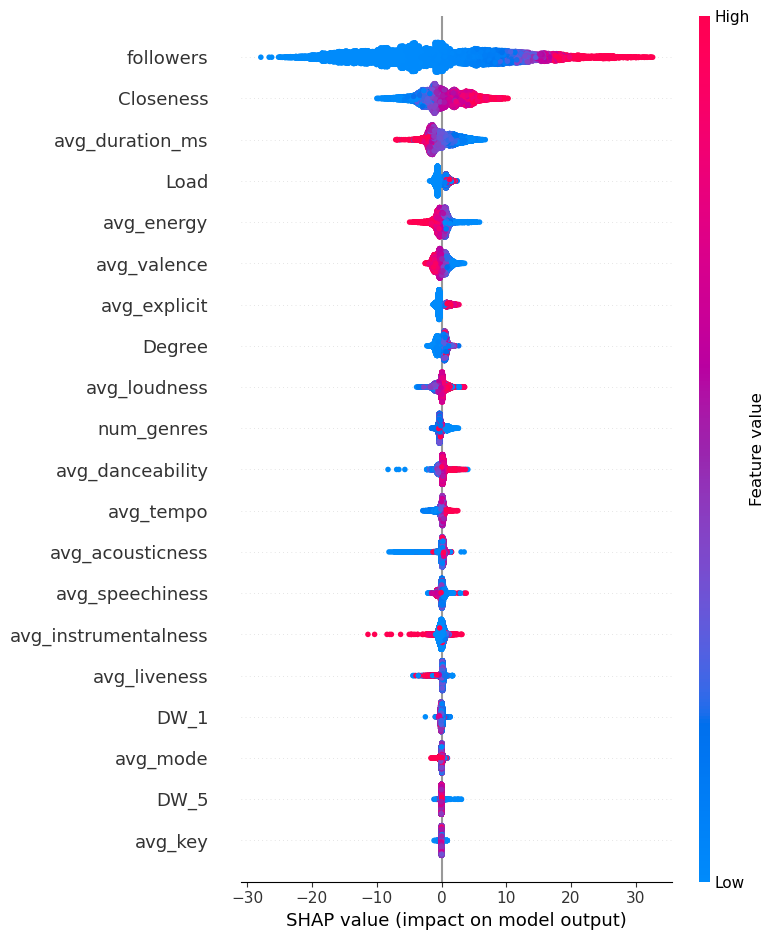

In [52]:
shap.summary_plot(shap_values, X_train)

In [53]:
# visualize the first prediction's explanation on Kendrick Lamar (true: 89)
kendrick_idx = list(X_train.index).index("2YZyLoL8N0Wb9xBt1NhZWg")
shap.force_plot(explainer.expected_value, shap_values[kendrick_idx,:], X_train.iloc[kendrick_idx,:])

In [54]:
# visualize the first prediction's explanation on Clemens Krauss, a classical musician (true: 26)
idx = list(X_train.index).index("0BD0yexvRf2lNmTwda3DvU")
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_train.iloc[idx,:], matplotlib=False)

### GAT

In [152]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16908 entries, 001oyhl94fb7YKL6fVqHOo to 7sK4hnuUOXw6VStDw0q8NI
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   followers             16908 non-null  float64
 1   num_genres            16908 non-null  int64  
 2   avg_duration_ms       16908 non-null  float64
 3   avg_explicit          16908 non-null  float64
 4   avg_danceability      16908 non-null  float64
 5   avg_energy            16908 non-null  float64
 6   avg_key               16908 non-null  float64
 7   avg_loudness          16908 non-null  float64
 8   avg_mode              16908 non-null  float64
 9   avg_speechiness       16908 non-null  float64
 10  avg_acousticness      16908 non-null  float64
 11  avg_instrumentalness  16908 non-null  float64
 12  avg_liveness          16908 non-null  float64
 13  avg_valence           16908 non-null  float64
 14  avg_tempo             16908 non-null 

In [55]:
data = from_networkx(graph)
data.x = X
data.y = y
data.y = torch.tensor(data.y)

In [56]:
id_to_number = dict(zip(graph.nodes, list(range(len(graph.nodes)))))
number_to_id = dict(zip(list(range(len(graph.nodes))), graph.nodes))

In [57]:
train_indices = [id_to_number[idx] for idx in X_train.index]
test_indices = [id_to_number[idx] for idx in X_test.index]

Different architectures

In [58]:
class GCN(torch.nn.Module):
    
    def __init__(self,input_channels,hidden_channels,output_channels):
        super().__init__()
        self.gcnconv1 = GCNConv(input_channels, hidden_channels)
        self.gcnconv2 = GCNConv(hidden_channels,hidden_channels)
        self.gcnconv3 = GCNConv(hidden_channels,output_channels)
        
        self.elu = nn.ELU()
        
    def forward(self, x,edge_index):
        x = self.elu(self.gcnconv1(x,edge_index))
        x = self.elu(self.gcnconv2(x,edge_index))
        x = F.dropout(x, p=0.2)
        x = self.gcnconv3(x,edge_index)
        return x

In [59]:
class GCN2(torch.nn.Module):
    
    def __init__(self,input_channels,hidden_channels,output_channels):
        super().__init__()
        self.gcnconv1 = GCNConv(input_channels, hidden_channels)
        self.gcnconv2 = GCNConv(hidden_channels,hidden_channels)
        self.gcnconv3 = GCNConv(hidden_channels,hidden_channels)
        self.gcnconv4 = GCNConv(hidden_channels,hidden_channels)
        self.gcnconv5 = GCNConv(hidden_channels,hidden_channels)
        self.gcnconv6 = GCNConv(hidden_channels,output_channels)
        
        self.elu = nn.ELU()
        
    def forward(self, x,edge_index):
        # no dropout so far
        x = self.elu(self.gcnconv1(x,edge_index))
        x = self.elu(self.gcnconv2(x,edge_index))
        x = self.elu(self.gcnconv3(x,edge_index))
        x = self.elu(self.gcnconv4(x,edge_index))
        x = self.elu(self.gcnconv5(x,edge_index))
        x = F.dropout(x, p=0.5)
        x = self.gcnconv6(x,edge_index)
        return x

In [60]:


class GAT(nn.Module):
      def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
      
        self.gat1 = graphnn.GATv2Conv(input_size, hidden_size, heads = 4)
        self.lin1 = torch.nn.Linear(input_size, 4 * hidden_size)
        self.gat2 = graphnn.GATv2Conv(hidden_size*4, hidden_size, heads = 4)
        self.lin2 = torch.nn.Linear(4 * hidden_size, 4*hidden_size)
        self.gat3 = graphnn.GATv2Conv(hidden_size*4, output_size, heads = 6, concat = False)
        self.lin3 = torch.nn.Linear(4 * hidden_size, output_size)
        self.dropout = nn.Dropout()
        self.elu = nn.ELU()

      
      def forward(self, x, edge_index):
        x1 = self.gat1(x, edge_index) + self.lin1(x)
        x1 = self.elu(x1)
        x2 = self.gat2(x1, edge_index) + self.lin2(x1)
        x2 = self.elu(x2)
        x2 = F.dropout(x2,p=0.5)
        x3 = self.gat3(x2, edge_index) + (self.lin3(x2))
        return x3

In [61]:
def train_val_test_split(data, train_indices, test_indices):
    # dataset size
    N = len(data.y)
    # we also want a validation set of 10% of the total dataset
    val_size = math.floor(N/10)
    print(val_size)
    
    val_indices = np.random.choice(train_indices,size = val_size, replace = False)
    train_indices = np.sort(np.setdiff1d(train_indices,val_indices))
    # obtain all indices in the dataset
    dataset_indices = torch.arange(N)
    train_mask = torch.isin(dataset_indices,torch.from_numpy(train_indices))
    val_mask = torch.isin(dataset_indices,torch.from_numpy(val_indices))
    test_mask = torch.isin(dataset_indices,torch.from_numpy(test_indices))
    
    return train_mask, val_mask, test_mask, val_indices
    
# Split the data based on the train_test split made before
#y_train = pd.Series(y_train)
#y_test = pd.Series(y_test)
train_mask, val_mask, test_mask, val_indices = train_val_test_split(data, np.array(train_indices), np.array(test_indices))

1690


In [62]:
X =  X.merge(pd.DataFrame.from_dict(id_to_number, orient = 'index', columns = ['ID']), how = 'left',left_index = True, right_index = True)
X = X.set_index('ID')
normalized_df=(X-X.mean())/X.std()
data.x = torch.tensor(normalized_df.values)

In [63]:
from sklearn.metrics import r2_score

def train(model, edge_index, x, y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask):
    best_val_r2 = 0
    model.train()

    
    for epoch in range(num_epochs):
        # Forward pass for all nodes
        pred = model(x.float(), edge_index)
        # Compute loss on training set: cross entropy loss requires class indices as long
        # and logits (non normalized) as floats
        train_loss = criterion(pred[train_mask].squeeze(), y[train_mask].float().squeeze())
        val_loss = criterion(pred[val_mask].squeeze(), y[val_mask].squeeze())
        #print(y[train_mask].numpy().shape, pred[train_mask].detach().numpy().shape)
        train_r2 = r2_score(y[train_mask].numpy(),pred[train_mask].detach().numpy().squeeze())
        val_r2 = r2_score(y[val_mask].numpy(),pred[val_mask].detach().numpy().squeeze())
        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_r2 < val_r2:
            best_val_r2 = val_r2

        # Backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 50 == 0:
            print('Epoch {}: train loss {:.4f}, val loss {:.4f} ,train R2: {:.4f}, val R2: {:.4f}'.format(
                epoch, train_loss, val_loss,train_r2, val_r2))

    

def test(model, edge_index, x, y, test_mask):
    model.eval()
    out = model(x.float(), edge_index)
    # make this R2-score
    #print(y[test_mask])
    #print(out[test_mask])
    r2 = r2_score(y[test_mask].numpy(),out[test_mask].detach().numpy())
    print(f'Test r2: {r2}')
    #print(confusion_matrix(labels[val_mask].numpy(),pred[val_mask].numpy(), normalize = 'true'))
    #print(confusion_matrix(labels[val_mask].numpy(),pred[val_mask].numpy()))


### GCN

In [64]:
torch.autograd.set_detect_anomaly(True)
hidden_size = 64
lr = 0.01
weight_decay = 0.0005
model = GCN(data.x.shape[1], hidden_size,1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 400, gamma=0.1)
criterion = torch.nn.MSELoss()
num_epochs = 1000
train(model, data.edge_index, data.x, data.y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask)  

Epoch 0: train loss 2584.3235, val loss 2639.7070 ,train R2: -9.6104, val R2: -9.2877
Epoch 50: train loss 237.5695, val loss 252.4561 ,train R2: 0.0246, val R2: 0.0161
Epoch 100: train loss 200.4781, val loss 208.4734 ,train R2: 0.1769, val R2: 0.1875
Epoch 150: train loss 190.7771, val loss 199.0630 ,train R2: 0.2167, val R2: 0.2242
Epoch 200: train loss 182.9106, val loss 192.4364 ,train R2: 0.2490, val R2: 0.2500
Epoch 250: train loss 177.9980, val loss 187.8504 ,train R2: 0.2692, val R2: 0.2679
Epoch 300: train loss 171.9799, val loss 183.7333 ,train R2: 0.2939, val R2: 0.2839
Epoch 350: train loss 169.4581, val loss 180.3728 ,train R2: 0.3043, val R2: 0.2970
Epoch 400: train loss 166.5595, val loss 179.9229 ,train R2: 0.3162, val R2: 0.2988
Epoch 450: train loss 165.3346, val loss 176.6500 ,train R2: 0.3212, val R2: 0.3115
Epoch 500: train loss 165.4289, val loss 178.5277 ,train R2: 0.3208, val R2: 0.3042
Epoch 550: train loss 164.9249, val loss 178.4744 ,train R2: 0.3229, val R2

In [65]:
test(model, data.edge_index, data.x, data.y, test_mask)

Test r2: 0.3097346175381829


### GCN 2

In [66]:
torch.autograd.set_detect_anomaly(True)
hidden_size = 64
lr = 0.01
weight_decay = 0.0005
model = GCN2(data.x.shape[1], hidden_size,1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 400, gamma=0.1)
criterion = torch.nn.MSELoss()
num_epochs = 1000
train(model, data.edge_index, data.x, data.y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask)  

Epoch 0: train loss 2571.2776, val loss 2625.0950 ,train R2: -9.5568, val R2: -9.2308
Epoch 50: train loss 232.2514, val loss 242.2473 ,train R2: 0.0465, val R2: 0.0559
Epoch 100: train loss 206.2402, val loss 215.6243 ,train R2: 0.1532, val R2: 0.1596
Epoch 150: train loss 188.1768, val loss 194.2362 ,train R2: 0.2274, val R2: 0.2430
Epoch 200: train loss 175.0869, val loss 187.4537 ,train R2: 0.2812, val R2: 0.2694
Epoch 250: train loss 168.1504, val loss 185.3264 ,train R2: 0.3096, val R2: 0.2777
Epoch 300: train loss 156.6649, val loss 175.7309 ,train R2: 0.3568, val R2: 0.3151
Epoch 350: train loss 160.5596, val loss 172.6266 ,train R2: 0.3408, val R2: 0.3272
Epoch 400: train loss 157.2336, val loss 179.9584 ,train R2: 0.3545, val R2: 0.2986
Epoch 450: train loss 149.4055, val loss 164.9587 ,train R2: 0.3866, val R2: 0.3571
Epoch 500: train loss 147.4598, val loss 164.8775 ,train R2: 0.3946, val R2: 0.3574
Epoch 550: train loss 147.2200, val loss 168.2081 ,train R2: 0.3956, val R2

In [67]:
test(model, data.edge_index, data.x, data.y, test_mask)

Test r2: 0.36981737286124694


### GAT

In [71]:
torch.autograd.set_detect_anomaly(True)
hidden_size = 128
lr = 0.01
weight_decay = 0.0005
model = GAT(data.x.shape[1], hidden_size,1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 400, gamma=0.1)
criterion = torch.nn.MSELoss()
num_epochs = 300
train(model, data.edge_index, data.x, data.y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask)  

Epoch 0: train loss 2598.0173, val loss 2651.6958 ,train R2: -9.6666, val R2: -9.3345
Epoch 50: train loss 97.3911, val loss 100.1748 ,train R2: 0.6001, val R2: 0.6096
Epoch 100: train loss 70.2219, val loss 74.9460 ,train R2: 0.7117, val R2: 0.7079
Epoch 150: train loss 52.1911, val loss 64.1064 ,train R2: 0.7857, val R2: 0.7502
Epoch 200: train loss 39.8531, val loss 61.3029 ,train R2: 0.8364, val R2: 0.7611
Epoch 250: train loss 30.3107, val loss 59.7704 ,train R2: 0.8756, val R2: 0.7671


In [72]:
test(model, data.edge_index, data.x, data.y, test_mask)

Test r2: 0.7228843037916668


# No followers

In [83]:
class NodeRegression:
    def __init__(self) -> None:
        self.cols_for_reg = [
            "followers","num_genres", 'avg_duration_ms', 'avg_explicit', 'avg_danceability', 'avg_energy', 'avg_key',
            'avg_loudness', 'avg_mode', 'avg_speechiness', 'avg_acousticness', 'avg_instrumentalness',
            'avg_liveness', 'avg_valence', 'avg_tempo', 'avg_time_signature', "artist_popularity"
        ]
        self.cols_to_drop = [
            "avg_track_popularity", "name", "genres", "followers"
        ]

    def create_data(self, artists_600_features, nodes_600):
        """Function to create graph and dataframe with features. We only keep artists in the graph if they have features associated to him or her.
        We also remove artists with null values."""
        # Subset graph based on feature availability
        artists_features_set = set(artists_600_features.index)
        edge_list_features = [tuple(l[:2]) for l in nodes_600.values.tolist() if (l[0] in artists_features_set and l[1] in artists_features_set)]
        G = ntx.from_edgelist(edge_list_features)
        g = G.subgraph(max(ntx.connected_components(G), key=len))
        df = artists_600_features.loc[list(g.nodes)]
        # Remove artists with NAs
        g = nx.Graph(g)
        artists_with_na = df[df.isnull().sum(axis=1) > 0].index
        g.remove_nodes_from(artists_with_na)
        df = df.dropna()
        if not nx.is_connected(g):
            print("Warning: Graph is not connected")
        # Add node attributes to graph
        g = self.add_node_attr(g, df)
        return g, df
    
    def get_df_reg(self, df):
        return df[self.cols_for_reg]
    
    """ def drop_nas(self, graph, df):
        artists_with_na = df[df.isnull().sum(axis=1) > 0].index
        graph = nx.Graph(graph)
        graph.remove_nodes_from(artists_with_na)
        df = df.dropna()
        if not nx.is_connected(graph):
            print("Warning: Graph is not connected")
        return graph, df """

    def add_node_attr(self, graph, df):
        dict = df.to_dict(orient="index")
        nx.set_node_attributes(graph, dict)
        return graph
    

    def fit_DW(self, graph, dims = 5, walk_length = 20, num_walks = 5, window = 2):
        deepwalk = DeepWalk(graph, dims=dims, walk_length = walk_length, num_walks=num_walks, window = window)
        walks = deepwalk.generate_walks()
        embeddings = deepwalk.skipgram()
        return embeddings
    
    def append_DW_embeddings(self,graph, df, dims = 5, walk_length = 20, num_walks = 5, window = 2):
        id_to_number = dict(zip(graph.nodes, list(range(len(graph.nodes)))))
        number_to_id = dict(zip(list(range(len(graph.nodes))), graph.nodes))

        embeddings = self.fit_DW(graph, dims=dims, walk_length = walk_length,  num_walks=num_walks, window = window)
        embeddings_df = pd.DataFrame([embeddings[id_to_number[node]] for node in graph.nodes()], columns = [f"DW_{i}" for i in range(1, dims+1)])
        embeddings_df['idx'] = [number_to_id[node] for node in embeddings_df.index]
        embeddings_df = embeddings_df.set_index('idx')
        df = df.merge(embeddings_df, how = 'left',left_index = True, right_index = True)
        return df
    
    

    def append_graph_criteria(self, graph, df):
        print("Computing degree")
        degrees = pd.Series(ntx.degree_centrality(graph))
        print("Computing closeness")
        closeness = pd.Series(ntx.closeness_centrality(graph))
        print("Computing load_centrality")
        load = pd.Series(ntx.load_centrality(graph))
        centralities = pd.concat([degrees,closeness,load], axis = 1)
        centralities.columns = ['Degree', 'Closeness', 'Load']
        df = df.merge(centralities, how = 'left',left_index = True, right_index = True)  
        return df


    def prepare_data_reg(self, df, test_size = 0.2, normalize = True):
        df = df.dropna()
        y = df["artist_popularity"]
        print("Dropped", self.cols_to_drop)
        X = df.drop(self.cols_to_drop + ["artist_popularity"], axis= 1)
        if normalize:
            X = (X-X.mean())/X.std()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        return X, y, X_train, X_test, y_train, y_test
    

    def get_graph_df_graph(self, artists_600_features, nodes_600, test_size = 0.2, include_DW = True, include_graph_criteria = True):
        graph, df_graph = self.create_data(artists_600_features, nodes_600)
        if include_DW:
            df_graph = self.append_DW_embeddings(graph, df_graph)
        if include_graph_criteria:
            df_graph = self.append_graph_criteria(graph, df_graph)
        return graph, df_graph

    def fit_evaluate_ols(self, X_train, X_test, y_train, y_test):
        ols = LinearRegression()
        ols.fit(X_train, y_train)
        r2 = ols.score(X_test, y_test)
        print("R2 score:", round(r2, 4))
        return ols
    
    def fit_sm_ols(self, df, test_size = 0.2):
        df_reg = df[self.cols_for_reg].dropna()
        y = df_reg["artist_popularity"]
        df_reg = df_reg.drop("artist_popularity", axis=1)
        df_train, df_test, y_train, y_test = train_test_split(df_reg, y, test_size=test_size)
        df_train = sm.add_constant(df_train)
        df_test = sm.add_constant(df_test)
        model = sm.OLS(y_train, df_train).fit()
        print(model.summary())
        return model

In [87]:
node_reg = NodeRegression()
graph, df_graph = node_reg.get_graph_df_graph(artists_600_features, nodes_600, include_graph_criteria=True, include_DW=True)
features = df_graph.drop(node_reg.cols_to_drop +["artist_popularity"] , axis= 1).columns
print(f'The largest connected component has {len(graph.nodes)} nodes.')
print(f'The largest connected component has {len(graph.edges)} edges.')
X, y, X_train, X_test, y_train, y_test = node_reg.prepare_data_reg(df_graph, normalize = True)

Computing degree
Computing closeness
Computing load_centrality
The largest connected component has 16908 nodes.
The largest connected component has 52233 edges.
Dropped ['avg_track_popularity', 'name', 'genres', 'followers']


R2 score: 0.6115


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

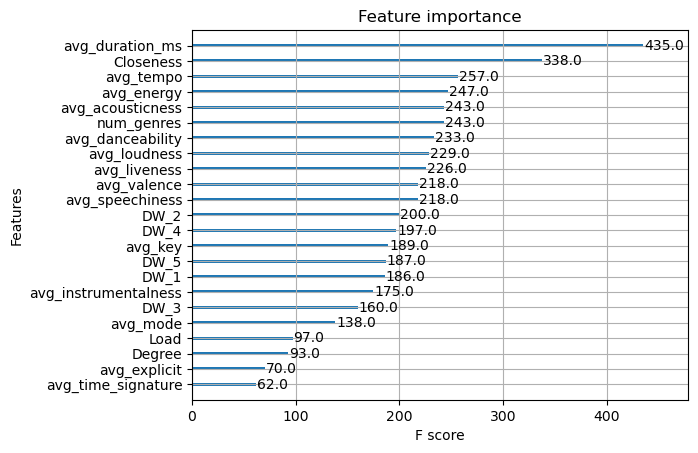

In [88]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb.get_booster().feature_names = list(features)
r2 = xgb.score(X_test, y_test)
print("R2 score:", round(r2, 4))
plot_importance(xgb.get_booster())